In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from blinky import Blinky
from datasets import load_dataset
from processor import BlinkyProcessor, save_tokenizer
import gc
from types import SimpleNamespace
from PIL import Image
from tqdm.auto import tqdm

In [2]:
config = SimpleNamespace(
    embed_dim = 576,
    intermediate_dim = 1536,
    max_position_embeddings = 8192,
    base_theta = 100000,
    num_q_heads = 9,
    num_kv_heads = 3,
    attn_dropout = 0.,
    num_layers = 30,
    vocab_size = 49152,
    eos_token_id = 2,
    dtype = torch.bfloat16,
    num_image_tokens = 196,
    vision_model_hf = 'google/siglip2-base-patch16-224',
    text_model_hf = 'HuggingFaceTB/SmolLM2-135M-Instruct'
)

In [ ]:
# save_tokenizer(config) # run to save tokenizer

In [3]:
processor = BlinkyProcessor('./Blinky')

In [4]:
model = Blinky(config).cuda()

In [5]:
model.load_state_dict(torch.load('./Blinky/stage2.pt'))

<All keys matched successfully>

In [13]:
def generate(
    model,
    processor,
    inputs,
    max_length=50,
    deterministic=False,
    temperature=1.0,
    enable_kv_cache=True,
):
    """
    Simplified generate function for a causal VLM.

    Args:
        model: The causal VLM model
        inputs: Dict containing 'input_ids', 'pixel_values', 'attention_mask'
        max_length: Maximum length of generated sequence
        temperature: Temperature for sampling (higher = more random)
        enable_kv_cache: Whether to use KV cache for faster generation

    Returns:
        generated_sequences: Tensor of shape [batch_size, sequence_length]
    """
    # Extract inputs
    input_ids = inputs["input_ids"].cuda()
    attention_mask = inputs["attention_mask"].cuda()
    pixel_values = inputs["pixel_values"].cuda() if inputs['pixel_values'] is not None else None


    # Initialize generated sequences with input_ids
    generated_sequences = input_ids.clone()
    current_length = generated_sequences.shape[1]

    # Setup KV cache
    if enable_kv_cache:
        model.text_model.enable_kv_cache()
        model.text_model.reset_kv_cache()
    else:
        model.text_model.disable_kv_cache()

    # First forward pass always includes all inputs
    with torch.no_grad():
        outputs = model(
            input_ids=input_ids,
            pixel_values=pixel_values,
            attention_mask=attention_mask
        )

    # Generate tokens one by one
    while current_length < max_length:
        # Get the next token logits and apply temperature
        next_token_logits = outputs[:, -1, :]
        if temperature != 1.0:
            next_token_logits = next_token_logits / temperature

        # Sample from the distribution
        probs = torch.nn.functional.softmax(next_token_logits, dim=-1)
        if deterministic:
            next_token = torch.argmax(probs, dim=-1, keepdim=True)
        else:
            next_token = torch.multinomial(probs, num_samples=1)

        # Add the sampled token to the output
        generated_sequences = torch.cat([generated_sequences, next_token], dim=1)
        current_length += 1

        # Create attention mask for the new token
        token_attention_mask = torch.ones_like(next_token).bool()

        # For subsequent forward passes
        with torch.no_grad():
            if enable_kv_cache:
                # With KV cache, only process the new token
                outputs = model(
                    input_ids=next_token,
                    attention_mask=token_attention_mask
                )
            else:
                # Without KV cache, process the full sequence
                attention_mask = torch.cat([attention_mask, token_attention_mask], dim=1)
                outputs = model(
                    input_ids=generated_sequences,
                    pixel_values=pixel_values,
                    attention_mask=attention_mask
                )

        if next_token.flatten().item() == processor.tokenizer.eos_token_id:
            break

    # Clean up KV cache if needed
    if enable_kv_cache:
        model.text_model.disable_kv_cache()

    return processor.tokenizer.decode(generated_sequences.flatten().cpu().numpy())

In [30]:
sample = [{
    'text': [{'role':'user','content':'what animal is that and what is it thinking?'}],
    'image': Image.open('./tests/monkey.jpg')
}]
inputs = processor(sample)

In [31]:
outputs = generate(
    model,
    processor,
    inputs,
    max_length = 200,
    enable_kv_cache = True,
    deterministic = False,
    temperature=0.5
)
print(outputs)

<|im_start|>system
You are a helpful AI assistant named Blinky with multimodal capabilities, trained by shreydan<|im_end|>
<|im_start|>user
what animal is that and what is it thinking?<|im_end|>
<|im_start|>assistant
The animal in the image is a monkey. Monkeys are known for their distinct facial expressions and behaviors, and their position in the image suggests that they might be thinking or feeling something. The monkey's presence in the scene indicates that it might be a member of a social group or a potentially intelligent animal.<|im_end|>


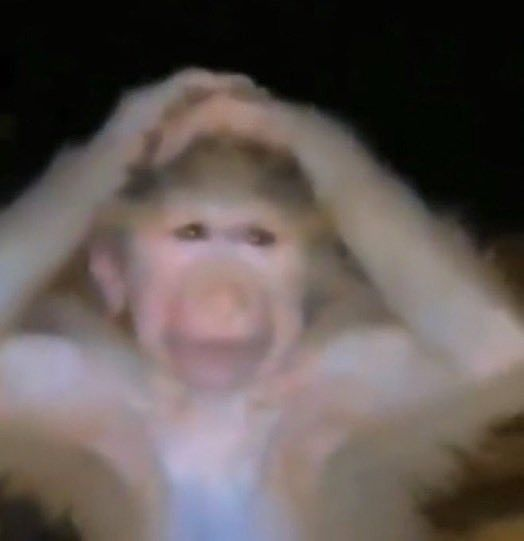

In [10]:
sample[0]['image']

In [21]:
sample = [{
    'text': [{'role':'user','content':'who is the current prime minister of India?'}],
}]
inputs = processor(sample)

In [28]:
outputs = generate(
    model,
    processor,
    inputs,
    max_length = 100,
    enable_kv_cache = True,
    deterministic = False,
    temperature=0.25
)
print(outputs)

<|im_start|>system
You are a helpful AI assistant named Blinky with multimodal capabilities, trained by shreydan<|im_end|>
<|im_start|>user
who is the current prime minister of India?<|im_end|>
<|im_start|>assistant
The current Prime Minister of India is Mr. Narendra Modi. He was elected as the first Prime Minister of India in 2014.<|im_end|>


In [32]:
sum(p.numel() for p in model.parameters())

230643264